In [6]:
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from skimage.measure import ransac
from skimage.transform import ProjectiveTransform, AffineTransform
import time

In [76]:
def draw_img(img):
    plt.figure(figsize=(15, 20))
    plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))


def get_sift_on_image(img, plot=False):
    '''
    Извлечение признаков методом SIFT,
    Если plot = True, рисуется изображение с признаками
    res - изображение с признаками, des - полученные дескрипторы
    kp - ключевые точки
    '''
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create()
    kp, des = sift.detectAndCompute(img, None)
    res = cv2.drawKeypoints(gray_img, kp, img, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    if plot:
        plt.figure(figsize=(10, 15))
        plt.imshow(img)

    return res, kp, des


def keypoints_matching(img1, kp1, des1, img2, kp2, des2, plot=False, threshold=8, trees=5, min_samples=4):
    '''
    Сопоставление изображений методами FLANN и RANSAC
    img1,kp1,des1 - изображение c помеченными ключевыми точками,
    ключевые точки и дескрипторы полученные методом SIFT для исходного изображения (на котором ищем)
    img2,kp2,des2 - аналогично img1,kp1,des1, только для изображения, которое мы ищем
    plot - определяет, нужно ли строить график
    threshold - пороговый параметр RANSAC
    min_samples - минимальное количество объектов для построения зависимости в RANSAC
    trees - количество деревьев в FLANN
    '''
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=trees)
    search_params = dict(checks=50)  # or pass empty dictionary
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1, des2, k=2)

    # Отсекаем плохие совпадения с помощью коэффициента Лоу
    good = []
    for i, (m, n) in enumerate(matches):
        if m.distance < 0.7 * n.distance:
            good.append(m)

    # Координаты сопоставленных точек на исходном изображении
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 2)
    # Координаты сопоставленных точек на изображении, точки которого мы пытаемся определить на исходном
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 2)

    # Используем алгоритм робастой регрессии Ransac
    model, inliers = ransac(
        (src_pts, dst_pts),
        AffineTransform, min_samples=min_samples,
        residual_threshold=threshold, max_trials=50
    )

    n_inliers = np.sum(inliers)

    inlier_keypoints_left = [cv2.KeyPoint(point[0], point[1], 1) for point in src_pts[inliers]]
    inlier_keypoints_right = [cv2.KeyPoint(point[0], point[1], 1) for point in dst_pts[inliers]]
    placeholder_matches = [cv2.DMatch(idx, idx, 1) for idx in range(n_inliers)]

    if plot:
        draw_params = dict(matchColor=(0, 255, 0),
                           singlePointColor=(255, 0, 0),
                           flags=cv2.DrawMatchesFlags_DEFAULT)

        image3 = cv2.drawMatches(img1, inlier_keypoints_left, img2, inlier_keypoints_right, placeholder_matches, None,
                                 **draw_params)

        plt.figure(figsize=(50, 100))
        plt.imshow(image3, ), plt.show()

    src_pts = np.float32([inlier_keypoints_left[m.queryIdx].pt for m in placeholder_matches]).reshape(-1, 2)
    dst_pts = np.float32([inlier_keypoints_right[m.trainIdx].pt for m in placeholder_matches]).reshape(-1, 2)

    return src_pts, dst_pts


In [77]:
# поиск по ключевым точкам, получить peak coord

def matchTemplate(path_img, path_pattern):

    # Load the input images
    input_image = cv2.imread(path_img)
    pattern_template = cv2.imread(path_pattern)

    # тут тодлжен быть свой код
    # необходимо найти ключевые точки и вывести координаты рамки
    t1 = time.time()
    ## Результат алгоритма SIFT на исходном изображении
    res_img, kp_img, des_img = get_sift_on_image(input_image)
    ## Результат алгоритма SIFT на паттерне
    res_pattern, kp_pattern, des_pattern = get_sift_on_image(pattern_template)
    
    ## Сопоставляем полученные ключевые точки с помощью FLANN Matcher и Алгоритма RANSAC
    src_pts, dst_pts = keypoints_matching(res_img, kp_img, des_img, res_pattern, kp_pattern, des_pattern)
    
#     max(src_pts[:,0]), max(src_pts[:,1])

    highlight_start = (round(min(src_pts[:,0])), round(min(src_pts[:,1])))
    highlight_end = (round(max(src_pts[:,0])), round(max(src_pts[:,1])))
    t2 = time.time()
    n_pixels = input_image.shape[0]*input_image.shape[1] + pattern_template.shape[0]*pattern_template.shape[1]
    
    return highlight_start, highlight_end, (t2-t1)/n_pixels*1e6


In [78]:
def show(input_image, pattern_template, highlight_start, highlight_end,row):
    cv2.rectangle(input_image,(row["x1"],row["y1"]), (row["x2"],row["y2"]),(255,0,0), 2)
    cv2.rectangle(input_image, highlight_start, highlight_end, 255, 2)
    # Visualize the pattern template and resulting image
    fig_instance, axes_arr = plt.subplots(1, 2, figsize=(10, 5))

    # Show the pattern template
    axes_arr[0].imshow(pattern_template, cmap='gray')
    axes_arr[0].set_title('Pattern Template')

    # Show the input image with the highlighted match
    axes_arr[1].imshow(input_image, cmap='gray')
    axes_arr[1].set_title('Pattern Highlighted')

    plt.show()

In [79]:
# iou

def iou(row, highlight_start, highlight_end):
    true_points_set = set([])
    pred_points_set= set([])

    for x in range(row["x1"], row["x2"]):
        for y in range(row["y1"], row["y2"]):
                true_points_set.add((x,y))

        for x in range(highlight_start[0],highlight_end[0]):
            for y in range(highlight_start[1], highlight_end[1]):
                pred_points_set.add((x,y))
    iou_metric = len(true_points_set.intersection(pred_points_set)) / len(true_points_set.union(pred_points_set))
    return iou_metric

In [80]:
# загрузка изображений, перебор
import statistics
from PIL import Image, ImageFilter
import numpy as np
import pandas as pd
dataset = pd.read_csv('dataset/annotation.csv', delimiter=';')
dataset.head()
iou_array=[]
veloc_array = []
for i in range(0,36):
    row = dataset.iloc[i]
    highlight_start, highlight_end,veloc =matchTemplate(f"dataset/{row['id']}.jpg", f"dataset/pattern/cropped_img_{row['id']}.jpg")
    iou_metric = iou(row,highlight_start,highlight_end)
    veloc_array.append(veloc)
    print(f"Скорость составила {veloc} с/Мп")
    print(f"Метрика IoU составила {iou_metric}")
    iou_array.append(iou_metric)

iou_mean = statistics.mean(iou_array)
veloc_mean = statistics.mean(veloc_array)
print("iou_mean",iou_mean)
print(f"veloc_mean is {veloc_mean}")

Скорость составила 1.115520945725072 с/Мп
Метрика IoU составила 0.6847956730769231
Скорость составила 1.1521429931779696 с/Мп
Метрика IoU составила 0.8405452542684047
Скорость составила 1.0118291647772193 с/Мп
Метрика IoU составила 0.7371428571428571
Скорость составила 0.8322863334627205 с/Мп
Метрика IoU составила 0.2797008547008547
Скорость составила 1.567658561639685 с/Мп
Метрика IoU составила 0.899733399533719
Скорость составила 1.23119802437838 с/Мп
Метрика IoU составила 0.5466123280692817
Скорость составила 0.9805020445843252 с/Мп
Метрика IoU составила 0.8277392054558153
Скорость составила 0.7506003132006415 с/Мп
Метрика IoU составила 0.6952959587590904
Скорость составила 0.7993427616273651 с/Мп
Метрика IoU составила 0.46083049104000867
Скорость составила 1.585874412943804 с/Мп
Метрика IoU составила 0.6449375866851595
Скорость составила 0.7394398514102142 с/Мп
Метрика IoU составила 0.9354046183742902
Скорость составила 0.6570700555280005 с/Мп
Метрика IoU составила 0.13234414263491

In [29]:
path_img = 'dataset/5.jpg'
pattern_path = 'dataset/pattern/cropped_img_5.jpg'
img = cv2.imread(path_img)
img_pattern = cv2.imread(pattern_path)

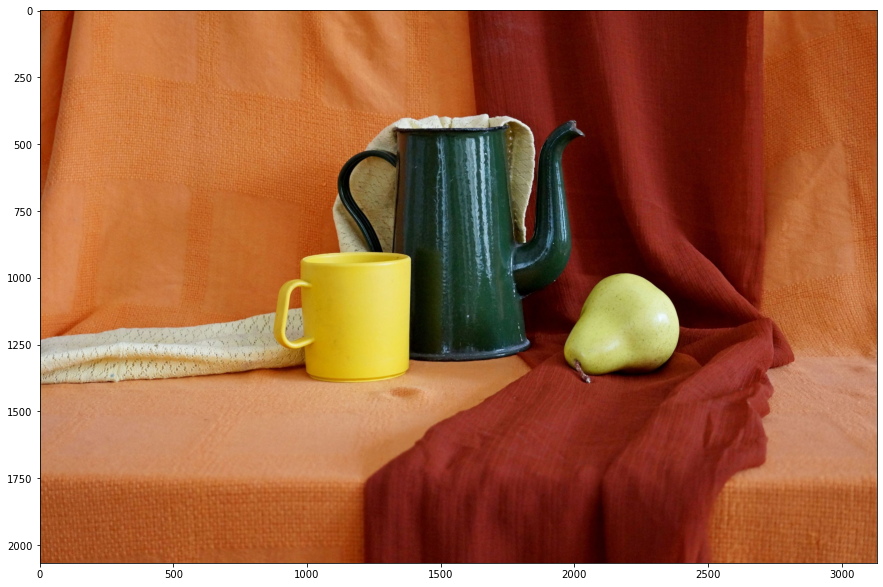

In [30]:
draw_img(img)

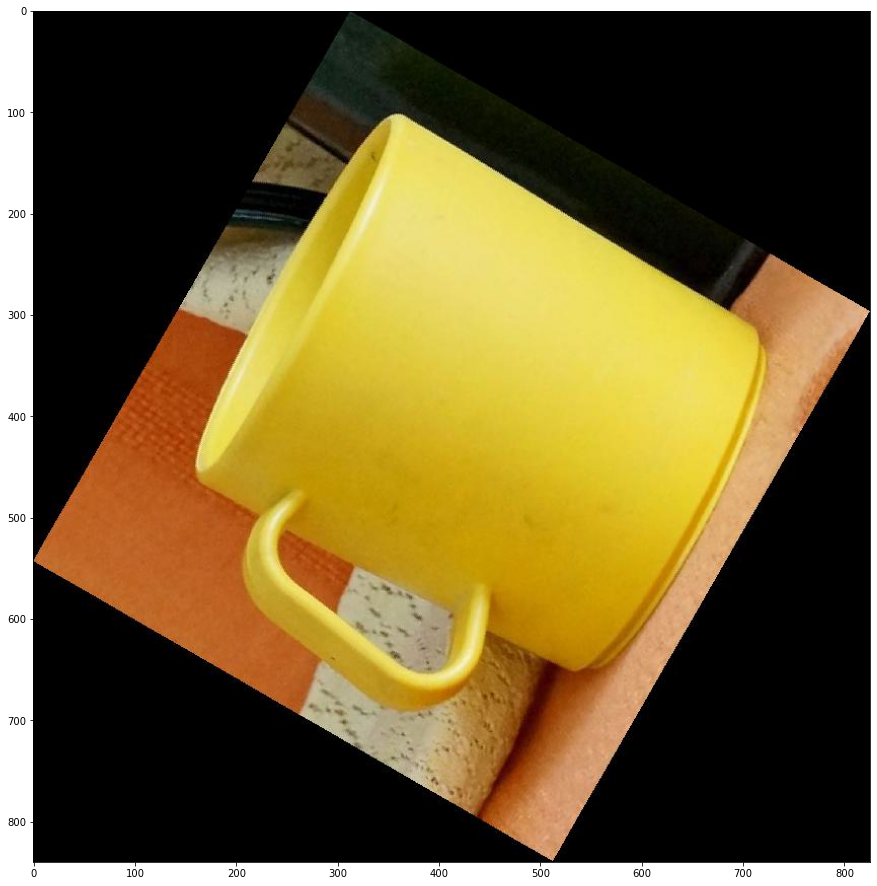

In [31]:
draw_img(img_pattern)

In [32]:
res_img, kp, des = get_sift_on_image(img)

In [33]:
res_img_pattern, kp_pattern, des_pattern = get_sift_on_image(img_pattern)

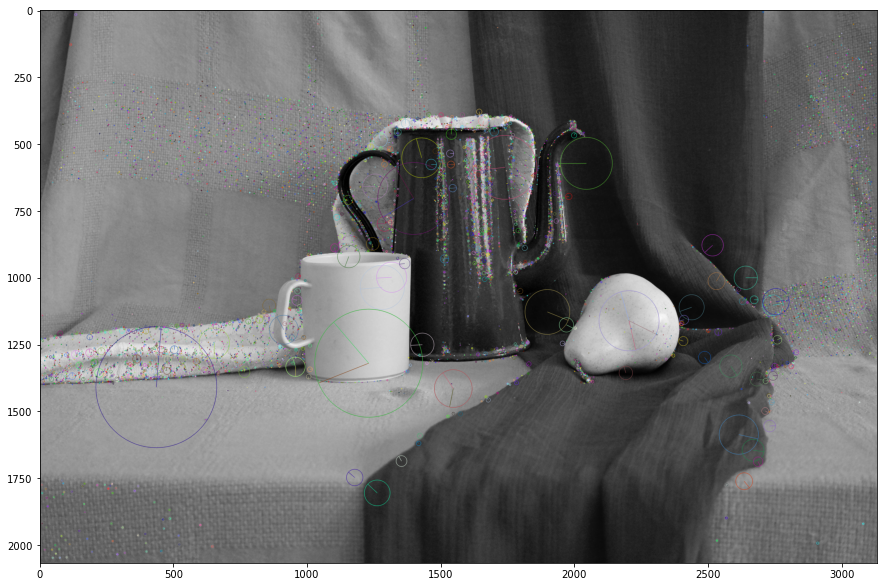

In [34]:
draw_img(res_img)

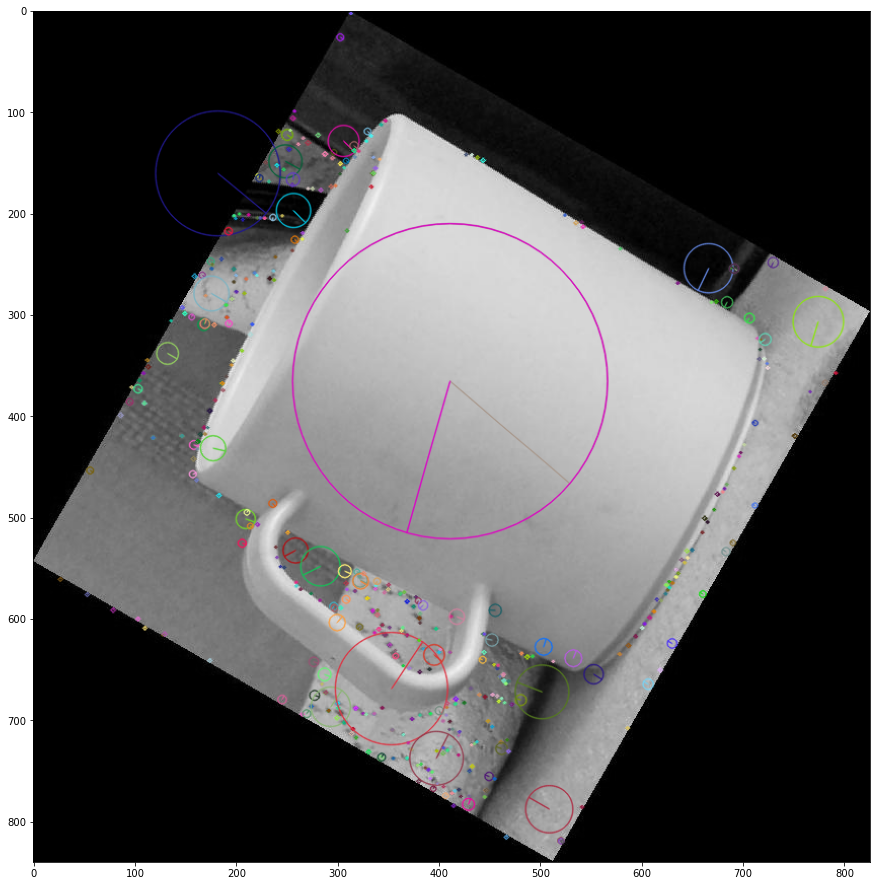

In [35]:
draw_img(res_img_pattern)

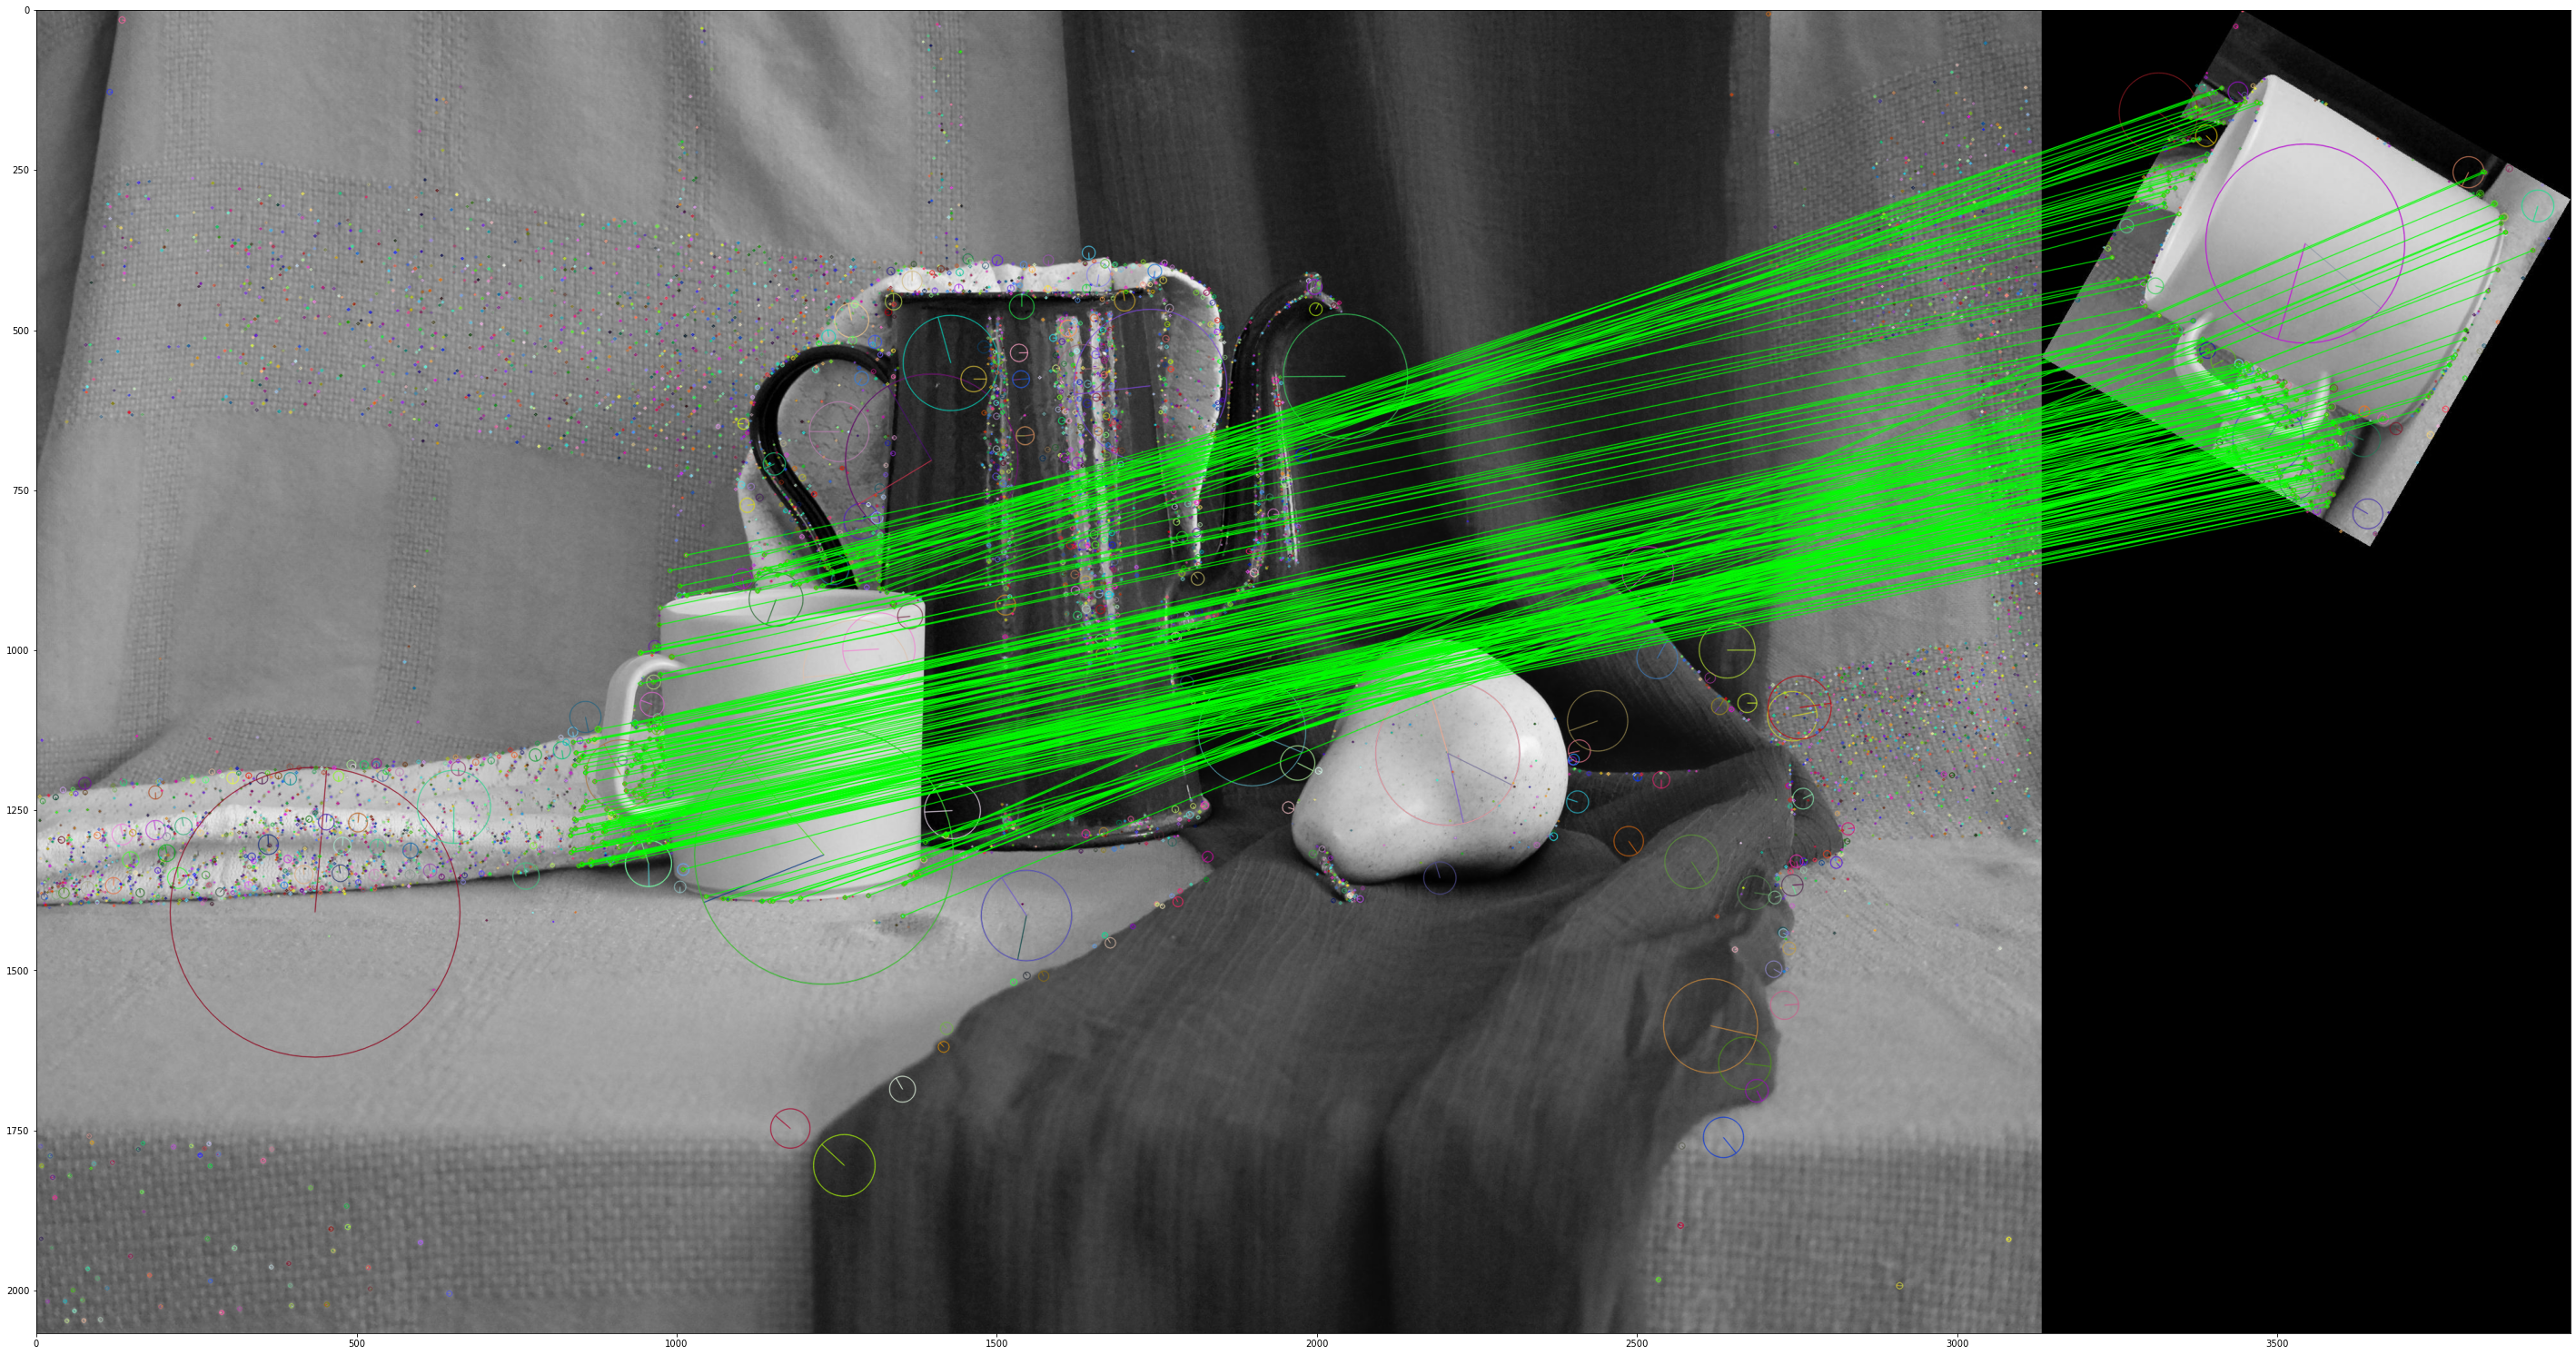

In [37]:
src_pts, dst_pts = keypoints_matching(res_img, kp, des, res_img_pattern, kp_pattern, des_pattern,plot = True)

In [41]:
dataset = pd.read_csv('dataset/annotation.csv', delimiter=';')
dataset.head()

id   x1   y1    x2    y2
0   1   99  223   307   287
1   2  560   73   820   492
2   3  300  240   510   490
3   4  641  490   771   670
4   5  825  835  1451  1427

In [42]:
max(src_pts[:,0]), max(src_pts[:,1])

(1420.3859, 1415.307)

In [43]:
min(src_pts[:,0]), min(src_pts[:,1])

(834.02997, 846.3468)